# Hyperspectral Remote Sensing Scenes Anlysis

In this homework you are asked to analyse the images collected from saltelites with hyperspectral cameras from a particular earth region.

## 1. Data preparation (20P)

* Download the _Indian Pines_ dataset from the 
__[Hyperspectral Data](http://www.ehu.eus/ccwintco/index.php/Hyperspectral_Remote_Sensing_Scenes)__  website in order to perform the classification. - DONE

* Split data into __train__ and __test__ set in proportions 80% to 20% - DONE

In [5]:
import numpy as np
import scipy.io
from sklearn.mixture import GaussianMixture
from sklearn.cluster import SpectralClustering
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.base import BaseEstimator, ClassifierMixin
import matplotlib.pyplot as plt
import spectral

### Explore Indian Pines data
This scene was gathered by AVIRIS sensor over the Indian Pines test site in North-western Indiana and consists of 145*145 pixels and 224 spectral reflectance bands in the wavelength range 0.4–2.5 10^(-6) meters.

Data shape: (145, 145, 200)
Labels shape: (145, 145)
Max. pixel value: (145, 145)


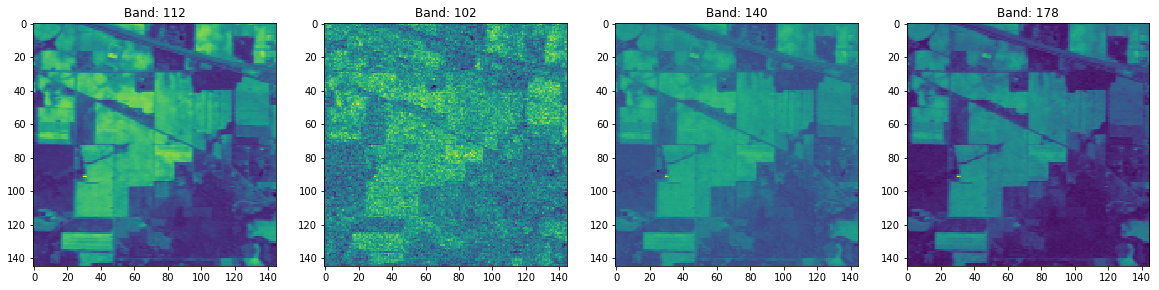

Text(0.5,1,'Ground Truth of pine data_set')

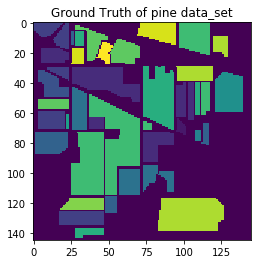

In [92]:
# load the data
data = scipy.io.loadmat('Indian_pines_corrected.mat')['indian_pines_corrected']
ground_truth = scipy.io.loadmat('Indian_pines_gt.mat')['indian_pines_gt']

# shapes
print(f"Data shape: {data.shape}")
print(f"Labels shape: {ground_truth.shape}")
print(f"Max. pixel value: {data.max(2).shape}")

# plot some sample bands
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4,figsize=(20,10))
i = np.random.randint(data.shape[2])
ax1.imshow(data[:,:,i])
ax1.set_title(f"Band: {i}")

i = np.random.randint(data.shape[2])
ax2.imshow(data[:,:,i])
ax2.set_title(f"Band: {i}")

i = np.random.randint(data.shape[2])
ax3.imshow(data[:,:,i])
ax3.set_title(f"Band: {i}")

i = np.random.randint(data.shape[2])
ax4.imshow(data[:,:,i])
ax4.set_title(f"Band: {i}")

plt.show()

plt.imshow(ground_truth)
plt.title("Ground Truth of pine data_set")

### Split the data

In [ ]:
# prepare data for split
data = data.reshape(-1,200)
ground_truth = ground_truth.reshape(-1)

training_data = data[:int(.8*data.shape[0])]
training_labels = ground_truth[:int(.8*ground_truth.shape[0])]

test_data = data[int(.8*data.shape[0]):]
test_labels = ground_truth[int(.8*ground_truth.shape[0]):]

print(f"Length of training set: {training_data.shape[0]}")
print(f"Length of test set: {test_data.shape[0]}")

## 2. Data Classification
In this section we'll apply different algorithms from the **_sklearn_** package in order to do find the best classification error.

### 2.1 Semi-supervised classification (40 P)

### Question: Use whole data set ?

* Draw 10% datapoints from each class to be used as semi-supervised labels and fix them. - DONE

* Perform the _Mixture of Gaussians_ (sklearn.mixture.GaussianMixture) clustering with full covariance matrices on the input space with the true number of classes. - DONE

* Perform the _Spectral Clustering_ (sklearn.cluster.SpectralClustering) on the feature space with the RBF kernel for building the affinity matrix with the true number of classes. - DONE

* Assign labels for each data point within a class using semi-supervised labels i.e. as maximum occurence within the class and compute the accuracy (sklearn.metrics.accuracy_score).  - DONE

* Use the accuracy metric in order to make a _scorer_ (sklearn.metrics.make_scorer) and perform cross-validation parameter tuning with the grid search engine (_GridSearchCV_ class) for both models. - CODE DONE / RUN IT

### Sample 10% of each label class and fix them

In [ ]:
# get distinct labels
distinct_labels = np.unique(training_labels)

# creates dictionary with indices of labeled class samples(10% of total class samples) from each class
# key: class label, value: list of indices of corresponding class samples(10%)
labeled_data_dict = dict()

# creates dictionary with indices of unlabeled class samples(90% of total class samples) from each class
# key: class label, value: list of indices of corresponding class samples(90%)
unlabeled_data_dict = dict()

# Get 10% of each class. Efficient loop, since we only iterate over indices
for label in distinct_labels:
    shuffled_indices = np.random.permutation(np.where(training_labels==label)[0])
    labeled_data_dict[label] = shuffled_indices[:int(.1*len(shuffled_indices))]
    unlabeled_data_dict[label] = shuffled_indices[int(.1*len(shuffled_indices)):]

# build inv labeled_data_indices dict
# key: data-sample index, value: assigned label
inv_labeled_data_dict = dict()
for k,v in labeled_data_dict.items():
    for v2 in v:
        inv_labeled_data_dict[v2] = k

# labeled training data indices
labeled_data_indices = np.concatenate(list(labeled_data_dict.values()))
# unlabeled training data indices
unlabeled_data_indices = np.concatenate(list(unlabeled_data_dict.values()))
        
# fixed labeled dataset
labeled_train_data = training_data[labeled_data_indices]
labeled_train_data_labels = training_labels[labeled_data_indices]
 
# fixed unlabeled data
unlabeled_train_data = training_data[unlabeled_data_indices]
unlabeled_train_data_labels = training_labels[unlabeled_data_indices]

In [ ]:
print(f"Length of training data: {training_data.shape[0]}")
print(f"Length of labeled data set: {labeled_train_data.shape[0]}")
print(f"Length of unlabeled data set: {unlabeled_train_data.shape[0]}")
print(f"Fraction of training data: {labeled_train_data.shape[0] / training_data.shape[0]} %")

### Gaussian Mixture Classifier

In [ ]:
class GMMClassifier(BaseEstimator, ClassifierMixin):
    
    def __init__(self, cov_type='full', max_iter=100, n_init=1):    
        self.cov_type = cov_type 
        self.max_iter = max_iter
        self.n_init = n_init
        
        self.gmm = GaussianMixture(
            n_components=len(distinct_labels),
            covariance_type=self.cov_type,
            max_iter=self.max_iter,
            n_init=self.n_init
        )
        
    def fit(self, X, y):
        self.gmm.fit(X)
        
        return self
        
    def predict(self, X, y=inv_labeled_data_dict):
        """Assign label to each cluster, according to max occ. of labeled points within those clusters
        Parameters:
            - data
            - labeled data
        Returns:
            - (re-)labeled gauss cluster predictions
        """
        clustered_data = self.gmm.predict(X)
        
        # assign labels to each cluster based on max occurence of label of 
        # labeled data samples within that cluster
        for cluster_id in np.unique(clustered_data):
            cluster_indices = np.argwhere(clustered_data == cluster_id)
            tmp_labels = []
    
            for index in cluster_indices:
                # get real data label if exists - only take labels from semi supervised data
                try:
                    tmp_label = y[index[0]]
                    tmp_labels.append(tmp_label)
                except:
                    continue
    
            if tmp_labels != []:
                # get most frequent label
                tmp_counts = np.bincount(tmp_labels)
                max_label = np.argmax(tmp_counts)
    
                # assign all cluster points to the max label
                clustered_data[cluster_indices] = max_label
        y = clustered_data
        
        return y
    
    def score(self, X, y=None):
        y_ = self.predict(X)
        
        return accuracy_score(y_true=y, y_pred=y_)

In [ ]:
classifier_gmm = GMMClassifier()
classifier_gmm = classifier_gmm.fit(training_data, training_labels)
cluster_predictions = gmm_test.predict(unlabeled_data)

In [ ]:
# Compute accuracy score
gauss_acc = accuracy_score(cluster_predictions, training_labels[unlabeled_data_indices])
print(f"Accuracy using Gaussian Mixture Clustering: {100*gauss_acc}%")

### Fine Tuning Hyper Parameters with Cross Validation

In [ ]:
params = {
    'cov_type': ['full', 'tied', 'diag', 'spherical'],
    'max_iter': [100,10,1],
    'n_init': [100,10,1]
}

grid = GridSearchCV(
            estimator=GMMClassifier(),
            param_grid=params,
            cv=3
)

grid = grid.fit(training_data, training_labels)

### Spectral clustering Classification
As you can see my local machine doesn't have enough memory capacity to compute the spectral clustering predictions, thus I moves this part of the computation to the cloud and will load the computed spec_clusters array in the next cell.

In [ ]:
class SpecTralClassifier(BaseEstimator, ClassifierMixin):
    
    def __init__(self, affinity='rbf'):    
        
        self.affinity=affinity 
        self.spec_clusterer = SpectralClustering(
            n_clusters=len(distinct_labels),
            affinity=self.affinity
        )
        
    def fit(self, X, y):
        self.y = y
        self.spec_clustering = self.spec_clusterer.fit(X)
        
        return self
        
    def predict(self, X, y=inv_labeled_data_dict):
        
        """Assign label to each cluster, according to max occ. of labeled points within those clusters
        Parameters:
            - data
            - labeled data
        Returns:
            - (re-)labeled gauss cluster predictions
        """
        clustered_data = self.spec_clustering.labels_
        
        # assign labels to each cluster based on max occurence of label of 
        # labeled data samples within that cluster
        for cluster_id in np.unique(clustered_data):
            cluster_indices = np.argwhere(clustered_data == cluster_id)
            tmp_labels = []
    
            for index in cluster_indices:
                # get real data label if exists - only take labels from semi supervised data
                try:
                    tmp_label = y[index[0]]
                    tmp_labels.append(tmp_label)
                except:
                    continue
    
            if tmp_labels != []:
                # get most frequent label
                tmp_counts = np.bincount(tmp_labels)
                max_label = np.argmax(tmp_counts)
    
                # assign all cluster points to the max label
                clustered_data[cluster_indices] = max_label
        y = clustered_data
        
        return y
    
    def score(self, X, y=None):
        y = self.y
        y_ = self.predict(X)
        print(y_.shape)
        return accuracy_score(y_true=y, y_pred=y_)

In [ ]:
spec_clusters = np.load("spectral_clustering_predictions.npy")

# Compute accuracy score
spec_acc = accuracy_score(spec_clusters, unlabeled_data_labels)
print(f"Accuracy using Spectral Clustering Classification: {100*spec_acc}%")

### Fine Tuning Hyper Parameters with Cross Validation

In [ ]:
params = {
    'gamma': [1000,100,10,1,0.1,0.01],
    'assign_labels': ['kmeans', 'discretize']
}

grid = GridSearchCV(
            estimator=SpecTralClassifier(),
            param_grid=params,
            cv=3
)

grid = grid.fit(training_data, training_labels)

### 2.2 Supervised classification (20 P)

* Run multiclass Support Vector Machine classification in order to find labels for the unlabeled pixels. 

* Compute the overall pixels-wise error for the data _test_ set.

* Use this metric in order to make a _scorer_ (_sklearn.metrics.make_scorer_) and perform cross-validation parameter tuning with the grid search engine (_GridSearchCV_ class).

### SVM multiclass classification

In [ ]:
svm = SVC()
svm.fit(labeled_train_data, labeled_train_data_labels)

In [ ]:
smv_predictions = svm.predict(unlabeled_train_data)
svm_acc = accuracy_score(smv_predictions, unlabeled_train_data_labels)
print(f"SVM classification accuracy on unlabeled training data: {round(svm_acc*100,1)}%")

### Pixel wise error on test set

In [ ]:
test_set_predictions = svm.predict(test_data)

svm_test_acc = accuracy_score(test_set_predictions, test_labels)
print(f"SVM test classification accuracy: {round(svm_test_acc*100,1)}%")

### Fine Tuning Hyper Parameters with Cross Validation

In [ ]:
# Define hyper-params to optimize
params = [
    {'C': [1000, 100, 10, 1, 0.1], 'kernel': ['linear']},
    {'C': [1000, 100, 10, 1, 0.1], 'gamma': ['scale', 'auto', 1000, 100, 10, 1, 0.1], 'kernel': ['rbf']},
    {'C': [1000, 100, 10, 1, 0.1], 'degree': [3, 2, 1], 'kernel': ['poly']},
    {'C': [1000, 100, 10, 1, 0.1], 'kernel': ['sigmoid']},
] 

# Define scorer
def test_scorer(test_data, test_labels):
    score = accuracy_score(test_data, test_labels)
    return score
    
accuracy_scorer = make_scorer(test_scorer, greater_is_better=True)

svm_grid = GridSearchCV(
    estimator=SVC(), 
    param_grid=params, 
    scoring=accuracy_scorer
)

svm_grid = svm_grid.fit(training_data, training_labels)

print(svm_grid.best_score_)
print(svm_grid.best_params_)

## 3. Data Visualization (20 P)

* Visualize your classification results as the __covermap__ (_spectral.imshow_ ) using different colors for each class and compare it visually with the __normal__ image representation. - TBD

* Does your __covermap__ respresent the analysed data properly or not ? Compute the overall pixels-wise classification error - TBD

## 4. Optional Task (+50 P)

* Define your own Deep Neural Network Architecture in order to defeat the best model you've already found from the previous tasks.

* Show that your resuls are better or similar to the results from the previous models empirically as well as visually.

In [88]:
import torch
import torchvision
import segmentation_models_pytorch as smp

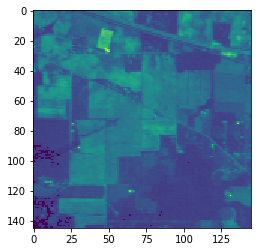

In [97]:
# pick 3 spectral bandwidths
plt.imshow(data[:,:,10])

In [154]:
raw_data = data
test_data = raw_data[:,:,3:6].transpose(2,1,0).astype(float)
test_data_tensor = torch.Tensor(test_data)
test_data_tensor.shape

torch.Size([3, 145, 145])

In [155]:
test_data_tensor = ((test_data_tensor-test_data_tensor.min()) / (test_data_tensor.max()-test_data_tensor.min()))

In [156]:
transform1 = torchvision.transforms.ToPILImage()
transform2 = torchvision.transforms.Resize(224)
transform3 = torchvision.transforms.ToTensor()

In [157]:
test_data_tensor = transform3(transform2(transform1(test_data_tensor)))

In [158]:
test_data_tensor = test_data_tensor.view(1,3,224,224)

In [159]:
model = smp.Unet('resnet34', encoder_weights='imagenet')

In [160]:
output = None
with torch.no_grad():
    output = model(test_data_tensor)

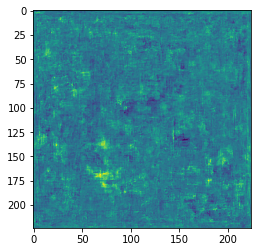

In [161]:
plt.imshow(output.view(224,224))